In [1]:
import os
import pandas as pd
import numpy as np
# import pysal as ps
import mapclassify
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
import geopandas as gpd
from shapely.geometry import Point
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from ipywidgets import interact

In [3]:
# Notebook Styling 
sns.set()
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data

I copied this from http://dph.illinois.gov/COVID19/STATISTICS, but soon I'll make a scraper to automatically pull new data when this notebook is run.

In [4]:
ZIP_SHAPEFILE_PATH = os.path.join('zip://', 'shapefiles', 'tl_2018_us_county.zip')
county_gdf = gpd.read_file(ZIP_SHAPEFILE_PATH)
cook_county_gdf = county_gdf.loc[county_gdf['GEOID'] == '17031'].copy()
cook_county_gdf.reset_index(drop=True, inplace=True)
cook_county_gdf.crs = 'EPSG:4326'
cook_county_gdf

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,031,01784766,17031,Cook,Cook County,06,H1,G4020,176,16980,16974,A,2447370818,1786313044,+41.8942937,-087.6454546,"POLYGON ((-88.23819 42.06698, -88.23819 42.067..."


In [5]:
ZIP_CODE_SHAPEFILE_PATH = os.path.join('zip://', 'shapefiles', 'tl_2010_17_zcta510.zip')
il_zip_code_gdf = gpd.read_file(ZIP_CODE_SHAPEFILE_PATH)
il_zip_code_gdf['INTPTLAT10'] = il_zip_code_gdf['INTPTLAT10'].astype(float)
il_zip_code_gdf['INTPTLON10'] = il_zip_code_gdf['INTPTLON10'].astype(float)
il_zip_code_gdf.crs = 'EPSG:4326'

cook_county_area_zip_gdf = il_zip_code_gdf.loc[(il_zip_code_gdf['INTPTLAT10'] <= 42.1700) & (il_zip_code_gdf['INTPTLON10'] >= -88.2600) & 
                                               (il_zip_code_gdf['INTPTLAT10'] >= 41.4700) & (il_zip_code_gdf['INTPTLON10'] <= -87.5200)].copy()
cook_county_area_zip_gdf.reset_index(drop=True, inplace=True)
cook_zip_gdf = gpd.overlay(cook_county_area_zip_gdf, cook_county_gdf, how='intersection')

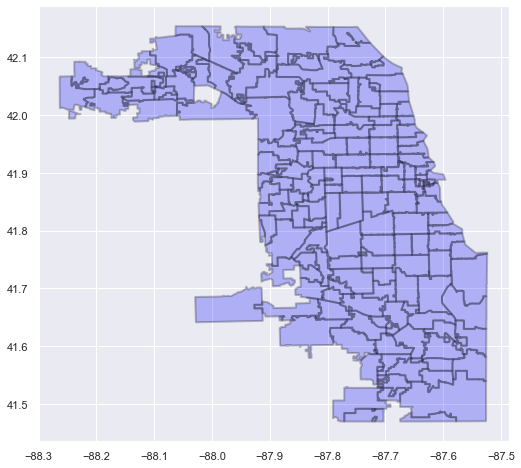

In [6]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = cook_zip_gdf.plot(figsize=figsize, color='blue', edgecolor='black', linewidth=2, alpha=0.25, ax=ax)

In [7]:
ZIP_SHP_PATH = os.path.join('zip://', 'shapefiles', 'Boundaries - City.zip')
chicago_boundary = gpd.read_file(ZIP_SHP_PATH)
chicago_boundary.crs = 'EPSG:4326'
chicago_zip_gdf = gpd.overlay(cook_county_area_zip_gdf, chicago_boundary, how='intersection')

In [8]:
chicago_zip_gdf.head(2)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,name,objectid,shape_area,shape_len,geometry
0,17,60453,1760453,B5,G6350,S,21904195,59,41.713437,-87.752560,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.72036 41.69196, -87.72034 ..."
1,17,60068,1760068,B5,G6350,S,18373706,77742,42.011762,-87.843434,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.81633 42.01875, -87.81633 ..."


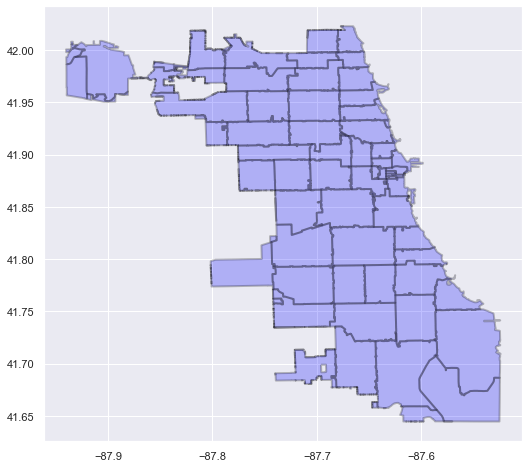

In [9]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = chicago_zip_gdf.plot(figsize=figsize, color='blue', edgecolor='black', linewidth=2, alpha=0.25, ax=ax)

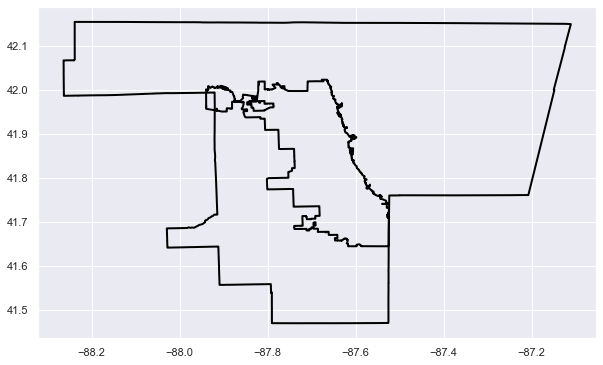

In [10]:
figsize=(10,8)
fig, ax = plt.subplots(figsize=figsize)
base = chicago_boundary.plot(figsize=figsize, color='none', edgecolor='black', linewidth=2, ax=ax)
ax = cook_county_gdf.plot(color='none', edgecolor='black', linewidth=2, ax=base)

In [11]:
CSV_PATH = os.path.join('data_raw', 'dph_illinois_by_zip_2020_04_07.csv')
covid_by_zip_df = pd.read_csv(CSV_PATH, dtype={'County':'object'})
covid_by_zip_df.rename({'County':'zip_code'}, axis=1, inplace=True)
covid_by_zip_cook_gdf = pd.merge(left=cook_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
covid_by_zip_chicago_gdf = pd.merge(left=chicago_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
covid_by_zip_cook_gdf['Positive Cases'] = covid_by_zip_cook_gdf['Positive Cases'].fillna(0)
covid_by_zip_chicago_gdf['Positive Cases'] = covid_by_zip_chicago_gdf['Positive Cases'].fillna(0)

In [12]:
covid_by_zip_chicago_gdf.head(2)

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,name,objectid,shape_area,shape_len,geometry,zip_code,Positive Cases,Deaths
0,17,60453,1760453,B5,G6350,S,21904195,59,41.713437,-87.752560,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.72036 41.69196, -87.72034 ...",60453,64.0,NaN
1,17,60068,1760068,B5,G6350,S,18373706,77742,42.011762,-87.843434,N,CHICAGO,1.0,6.450277e+09,845282.931362,"MULTIPOLYGON (((-87.81633 42.01875, -87.81633 ...",60068,54.0,NaN


In [13]:
# CSV_PATH = os.path.join('data_raw', 'dph_illinois_by_zip_2020_04_07.csv')
# covid_by_zip_df = pd.read_csv(CSV_PATH, dtype={'County':'object'})
# covid_by_zip_df.rename({'County':'zip_code'}, axis=1, inplace=True)
# covid_by_zip_gdf = pd.merge(left=cook_zip_gdf, right=covid_by_zip_df, how='left', left_on='ZCTA5CE10', right_on='zip_code')
# covid_by_zip_gdf['Positive Cases'] = covid_by_zip_gdf['Positive Cases'].fillna(0)

In [14]:
def map_covid19_cases_by_location(gdf, location, figsize=(15,15), scale=0.6, 
                                  alpha=0.6, cmap='OrRd', col='Positive Cases'):
    fig, ax = plt.subplots(figsize=figsize)
    ax = gdf.plot(column=col, figsize=figsize,  cmap=cmap, edgecolor='black', linewidth=2, ax=ax)
    ax.set_title(f'Confirmed COVID-19 Cases in {location} by Zip Code on 2020-04-07', fontsize=20)
    ax = ax.axis('off')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=gdf[col].max()))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    cbar.set_label('COVID-19 Cases by Zip Code', size=20)
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()

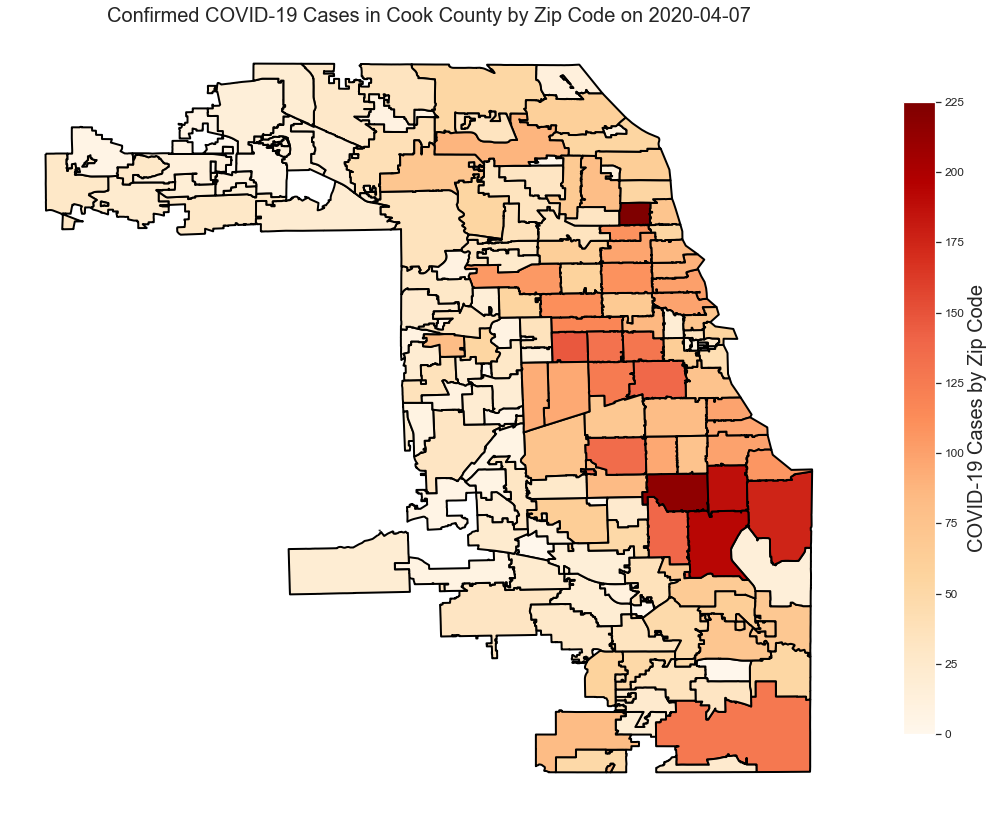

In [15]:
map_covid19_cases_by_location(gdf=covid_by_zip_cook_gdf, location="Cook County", figsize=(15,15), scale=0.6, 
                                  alpha=1, col='Positive Cases')

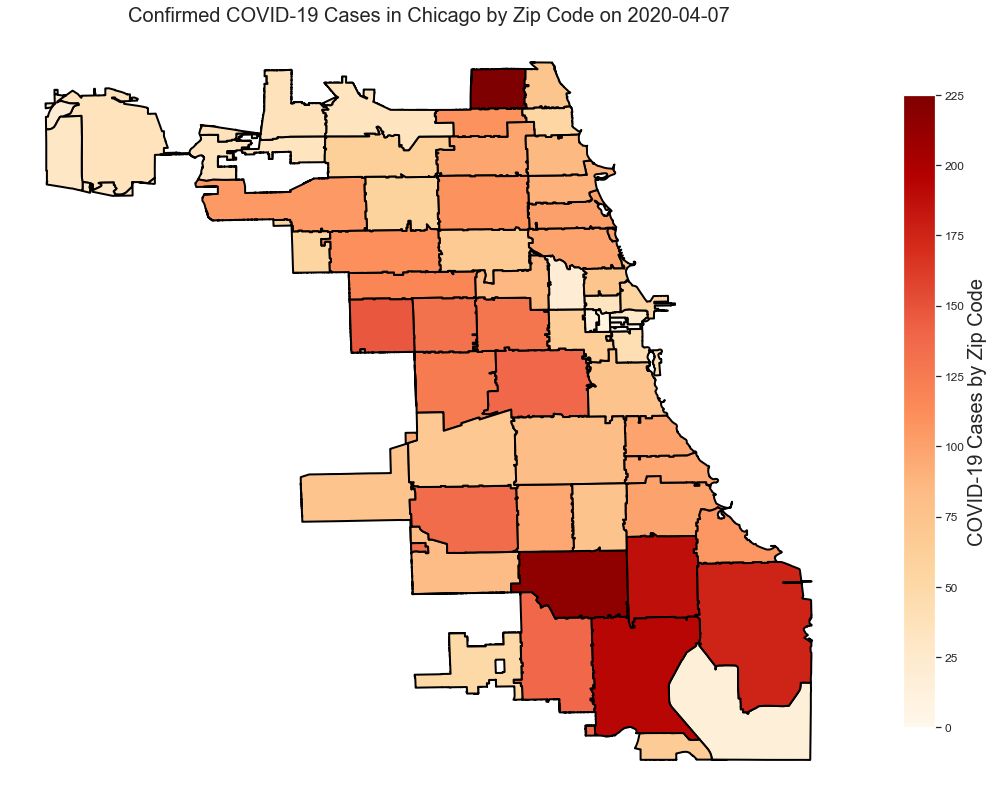

In [16]:
map_covid19_cases_by_location(gdf=covid_by_zip_chicago_gdf, location="Chicago", figsize=(15,15), scale=0.6, 
                                  alpha=1, col='Positive Cases')

In [17]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [18]:
def map_covid19_cases_by_location_shifted(gdf, location, figsize=(15,15), scale=0.6, 
                                  alpha=0.6, cmap=mpl.cm.coolwarm, col='Positive Cases', mp=0.1):
    my_cmap=shiftedColorMap(cmap, midpoint=mp, name='shifted')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = gdf.plot(column=col, figsize=figsize,  cmap=my_cmap, edgecolor='black', linewidth=2, ax=ax)
    ax.set_title(f'Confirmed COVID-19 Cases in {location} by Zip Code on 2020-04-07', fontsize=20)
    ax = ax.axis('off')
    
    vmin = gdf[col].min()
    vmax = gdf[col].max()    
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    cbar.set_label('COVID-19 Cases by Zip Code', size=20)
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()

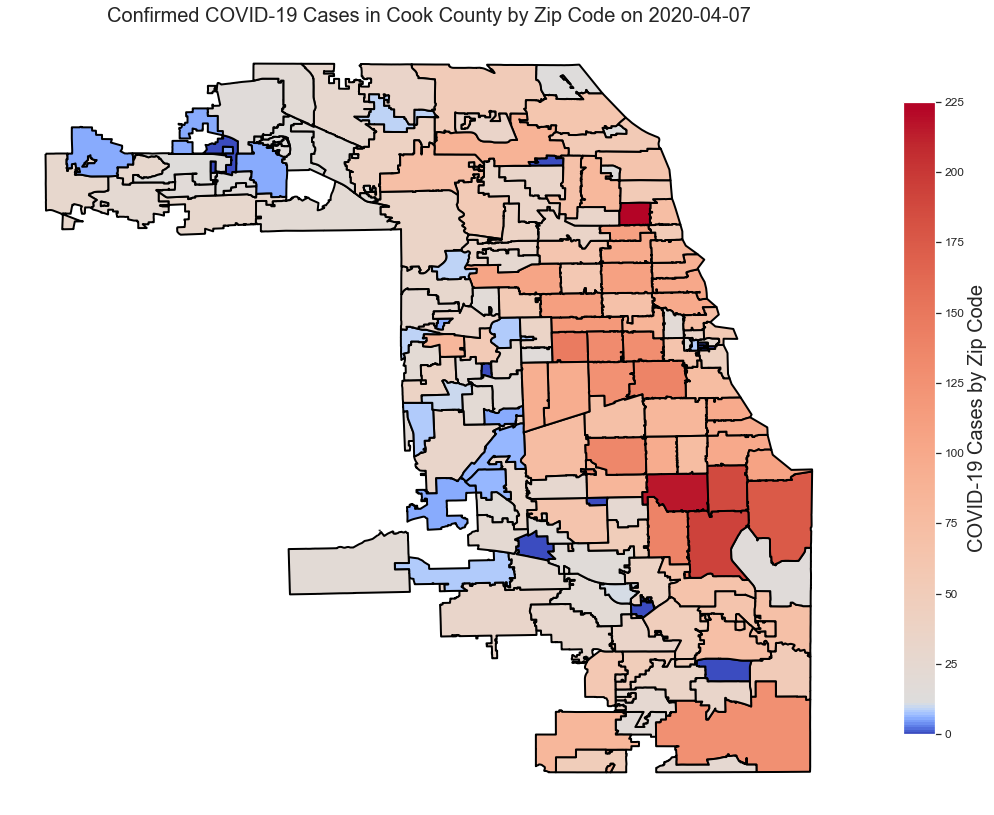

In [19]:
map_covid19_cases_by_location_shifted(gdf=covid_by_zip_cook_gdf, location="Cook County", figsize=(15,15), scale=0.6, 
                                  alpha=0.6, col='Positive Cases', mp=0.05)

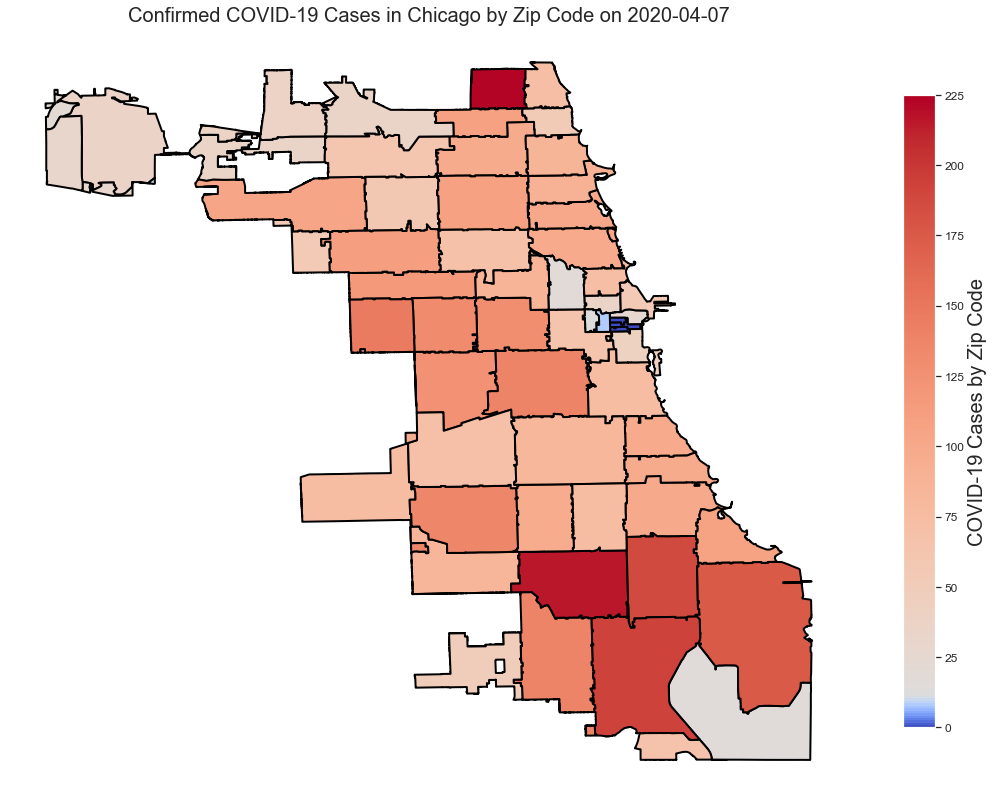

In [20]:
map_covid19_cases_by_location_shifted(gdf=covid_by_zip_chicago_gdf, location="Chicago", figsize=(15,15), scale=0.6, 
                                  alpha=0.6, col='Positive Cases', mp=0.05)

In [21]:
def map_covid19_cases_by_location_shifted(gdf, location, figsize=(15,15), scale=0.6, 
                                  alpha=0.6, cmap=mpl.cm.coolwarm, col='Positive Cases', mp=0.1):
    my_cmap=shiftedColorMap(cmap, midpoint=mp, name='shifted')
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = gdf.plot(column=col, figsize=figsize,  cmap=my_cmap, edgecolor='black', linewidth=2, ax=ax)
    ax.set_title(f'Confirmed COVID-19 Cases in {location} by Zip Code on 2020-04-07', fontsize=20)
    ax = ax.axis('off')
    
    vmin = gdf[col].min()
    vmax = gdf[col].max()    
    
    sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    cbar.set_label('COVID-19 Cases by Zip Code', size=20)
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()

In [22]:
def get_binning_scheme(data_series, scheme='quantile', k=5):
    if scheme == 'boxplot':
        return mapclassify.BoxPlot(data_series, k=k)
    elif scheme == 'equalinterval':
        return mapclassify.EqualInterval(data_series, k=k)
    elif scheme == 'fisherjenks':
        return mapclassify.FisherJenks(data_series, k=k)
    elif scheme == 'fisherjenkssampled':
        return mapclassify.FisherJenksSampled(data_series)
    elif scheme == 'headtailbreaks':
        return mapclassify.HeadTailBreaks(data_series)
    elif scheme == 'jenkscaspall':
        return mapclassify.JenksCaspall(data_series, k=k)
    elif scheme == 'jenkscaspallforced':
        return mapclassify.JenksCaspallForced(data_series, k=k)
    elif scheme == 'jenkscaspallsampled':
        return mapclassify.JenksCaspallSampled(data_series, k=k)
    elif scheme == 'maxp':
        return mapclassify.MaxP(data_series, k=k)
    elif scheme == 'maximumbreaks':
        return mapclassify.MaximumBreaks(data_series, k=k)
    elif scheme == 'naturalbreaks':
        return mapclassify.NaturalBreaks(data_series, k=k)
    elif scheme == 'percentiles':
        return mapclassify.Percentiles(data_series, k=k)
    elif scheme == 'stdmean':
        return mapclassify.StdMean(data_series, k=k)
    elif scheme == 'userdefined':
        return mapclassify.UserDefined(data_series, k=k)
    else:
        return mapclassify.Quantiles(data_series, k=k)

In [23]:
def map_covid19_cases_by_location_bin_scheme(gdf, location, scheme='quantiles', k=5, figsize=(12,12), scale=0.6, alpha=1, 
                                             cmap=mpl.cm.YlOrRd, col='Positive Cases', include_cbar=False, include_dist=False):
    """Available binning schemes: 
        'boxplot', 'equalinterval', 'fisherjenks', 'fisherjenkssampled', 'headtailbreaks', 
        'jenkscaspall', 'jenkscaspallforced', 'jenkscaspallsampled', 'maxp', 'maximumbreaks',
        'naturalbreaks', 'quantiles', 'percentiles', 'stdmean', 'userdefined'
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax = gdf.plot(column=col, figsize=figsize, cmap=cmap, legend=True, scheme=scheme, k=k, edgecolor='black', linewidth=2, 
                  ax=ax, alpha=alpha, legend_kwds={'fontsize':20, 'markerscale':2.5})
    ax.set_title(f'Confirmed COVID-19 Cases in {location} by Zip Code on 2020-04-07', fontsize=20)
#     ax.legend(fontsize=16)
    ax = ax.axis('off')    
    
    if include_cbar:
        vmin = gdf[col].min()
        vmax = gdf[col].max()
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        cbar = fig.colorbar(sm, shrink=scale, alpha=alpha)
        cbar.set_label('COVID-19 Cases by Zip Code', size=20)
        cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    
    if include_dist:
        fig, ax = plt.subplots(figsize=(8,5))
        sns.kdeplot(gdf[col], shade=True)
        sns.rugplot(gdf[col], alpha=0.5)
        classi = get_binning_scheme(data_series=gdf[col], scheme=scheme, k=k)
        for cut in classi.bins:
            plt.axvline(cut, color='red', linewidth=0.75)
        ax.set_title(f'Distribution of case counts with binning lines\n({scheme.capitalize()} binning scheme)', fontsize=16)

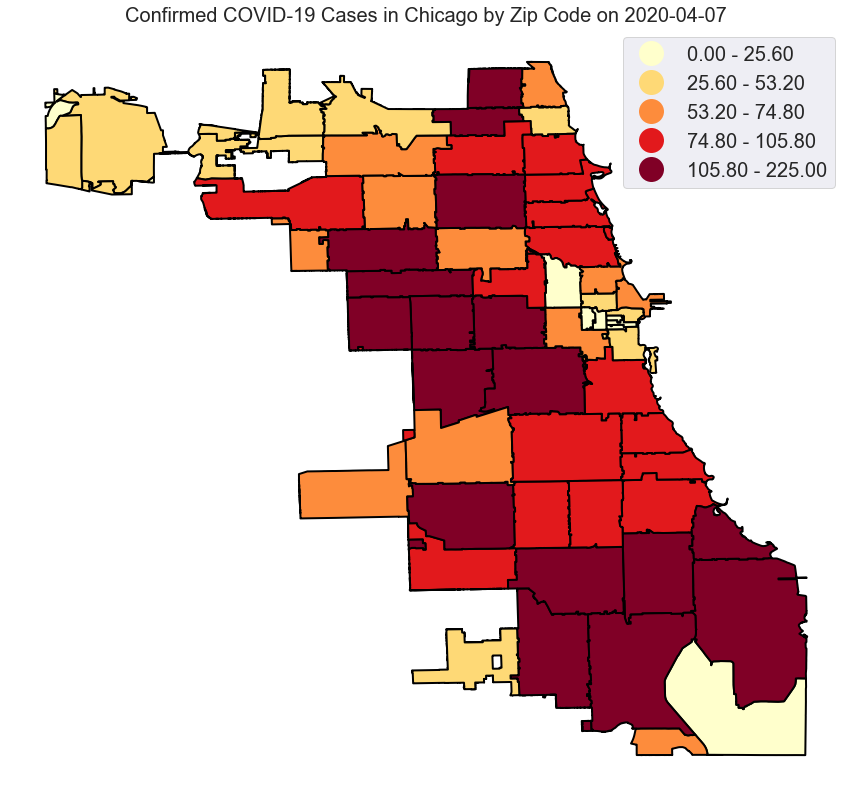

In [24]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='quantiles', k=5, scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, include_dist=False)

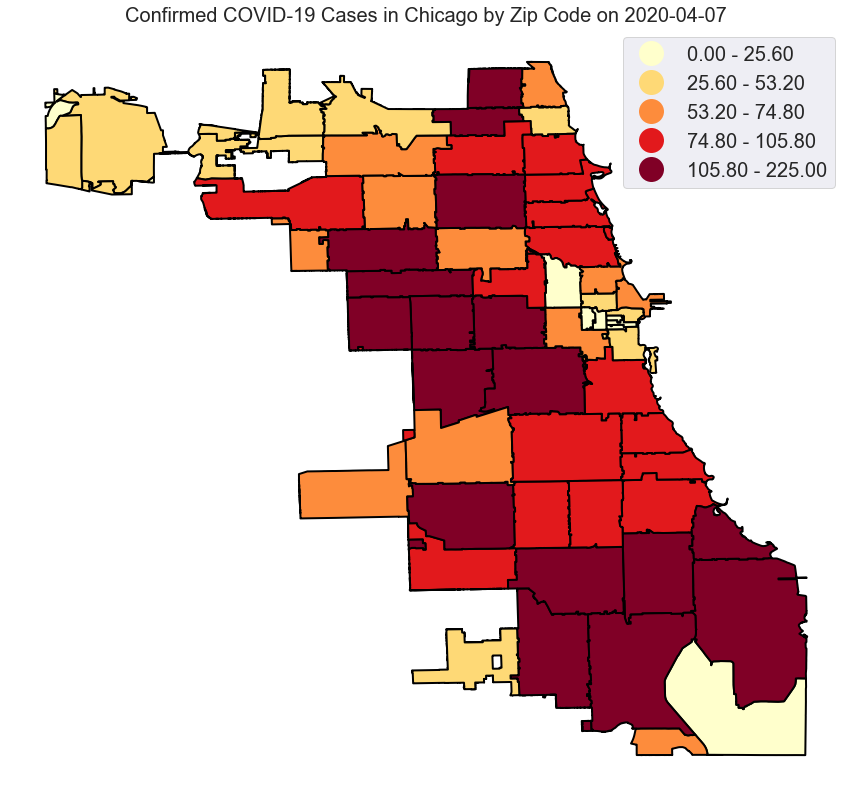

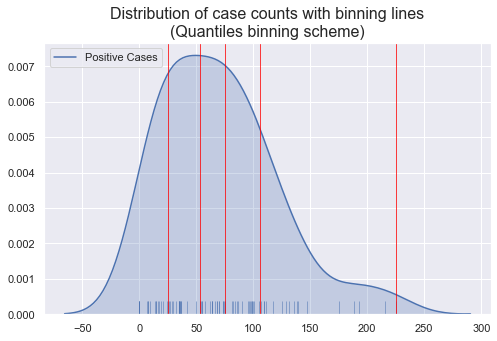

In [25]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='quantiles', k=5, scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, include_dist=True)

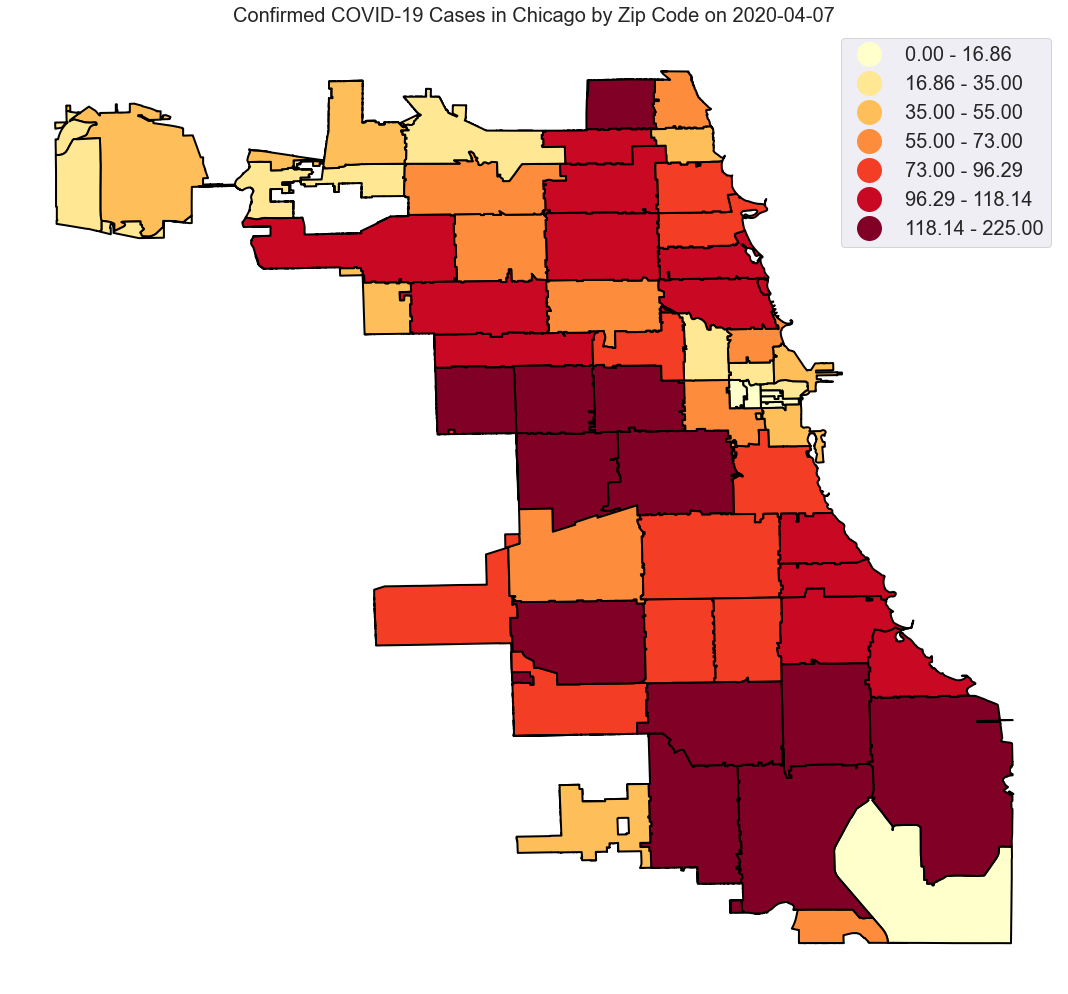

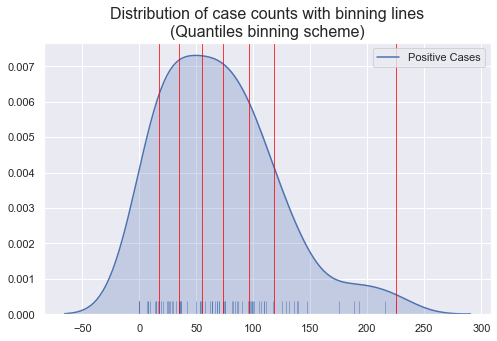

In [26]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='quantiles', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, include_dist=True)

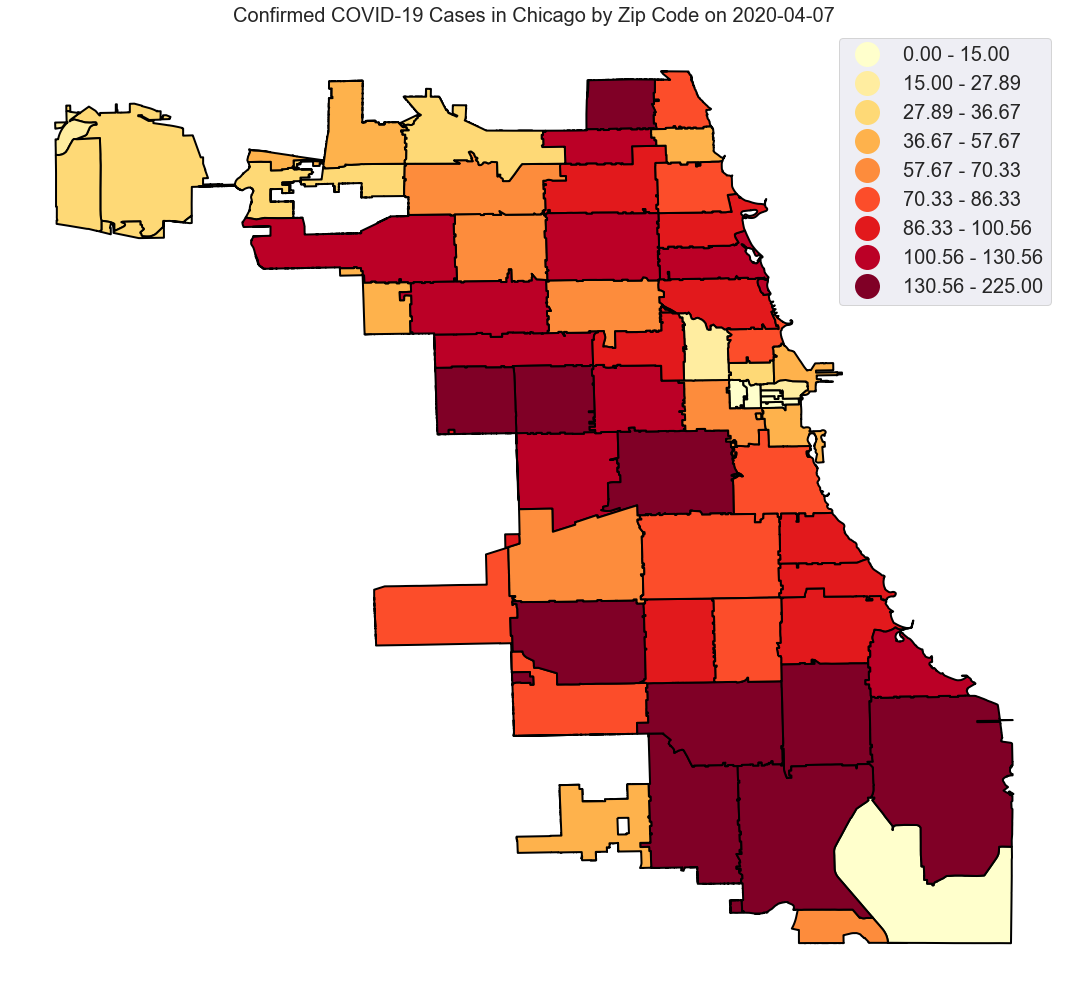

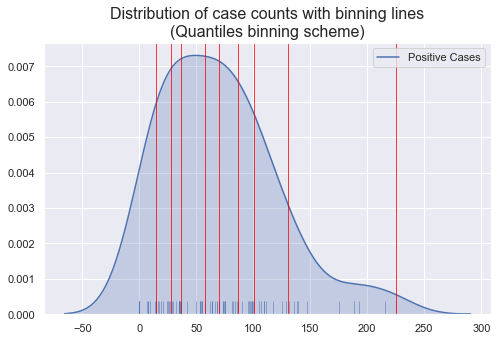

In [27]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='quantiles', k=9, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)

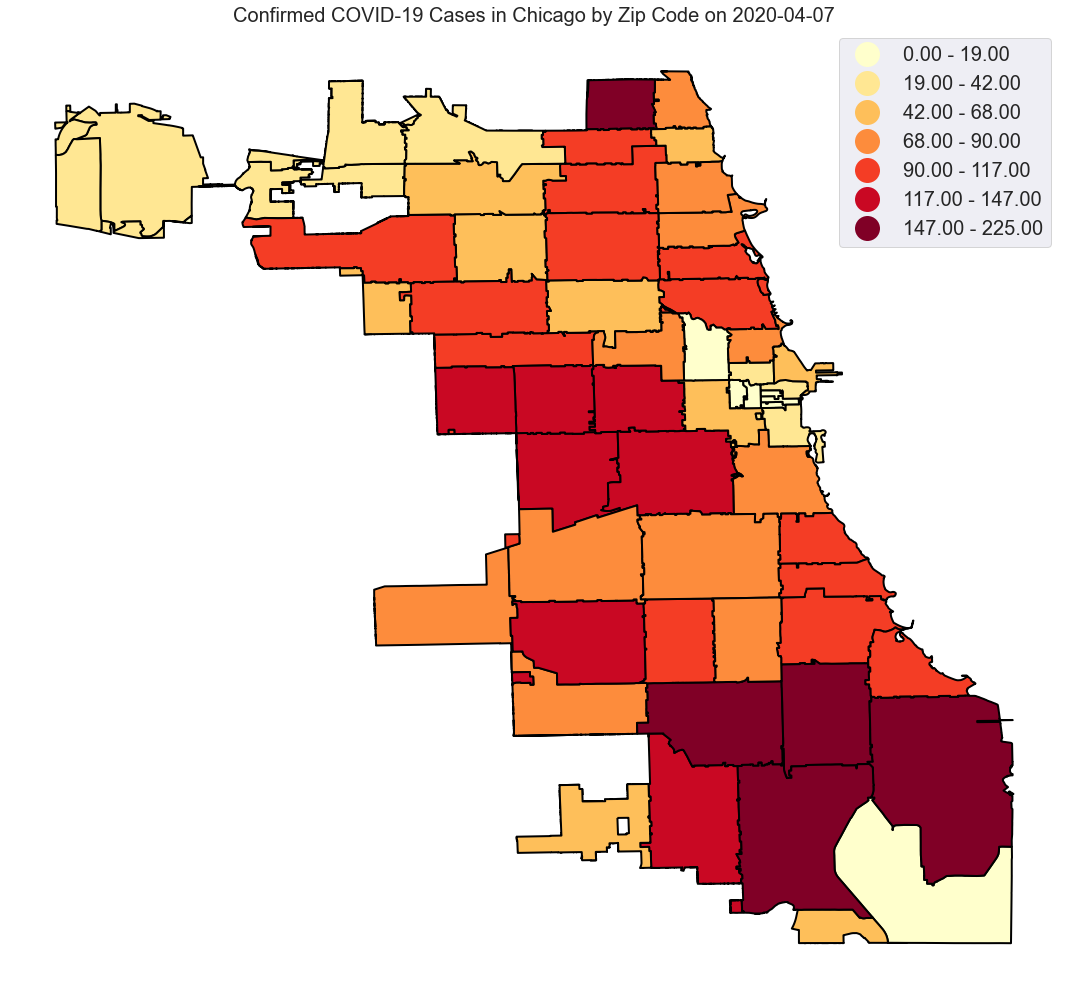

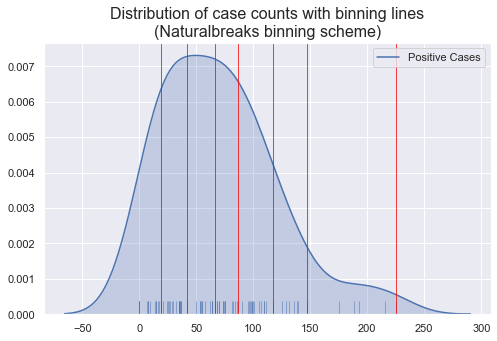

In [28]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='naturalbreaks', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)

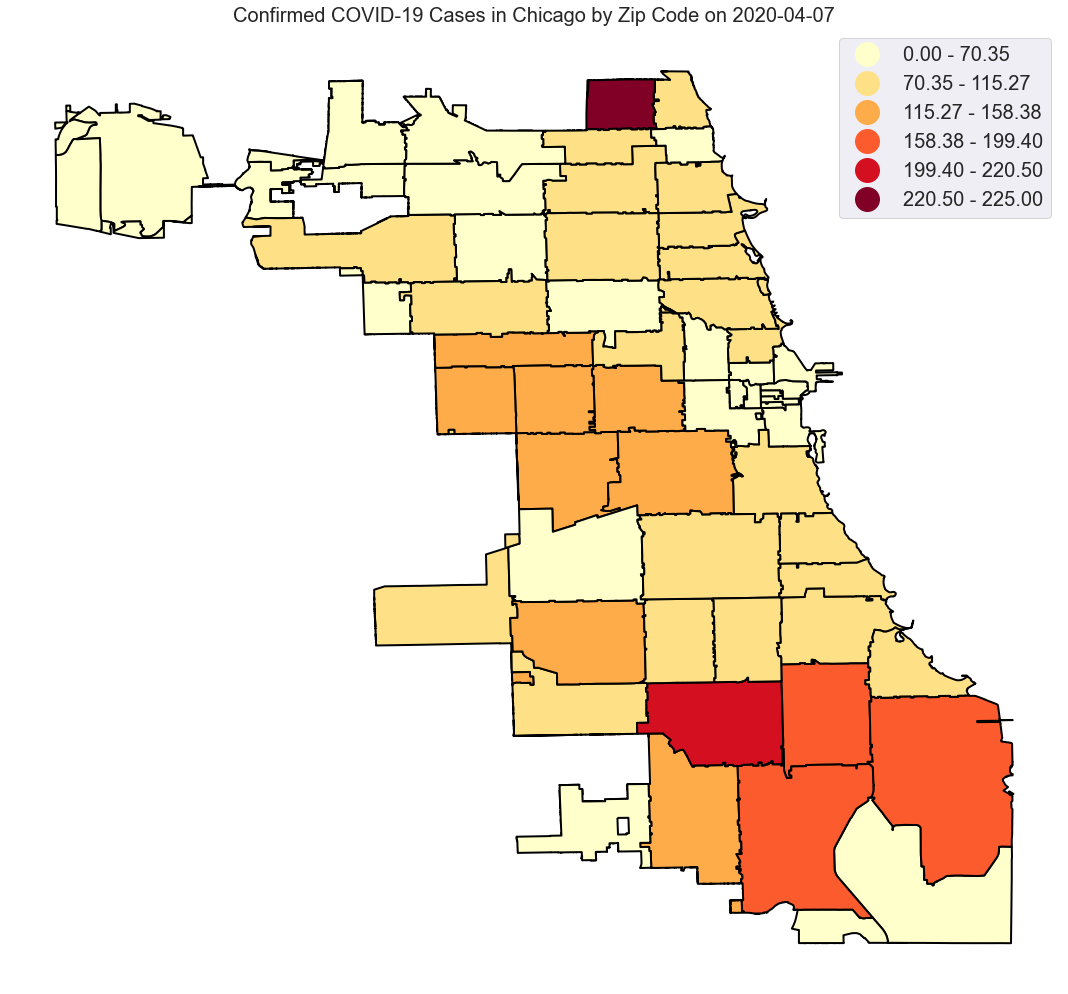

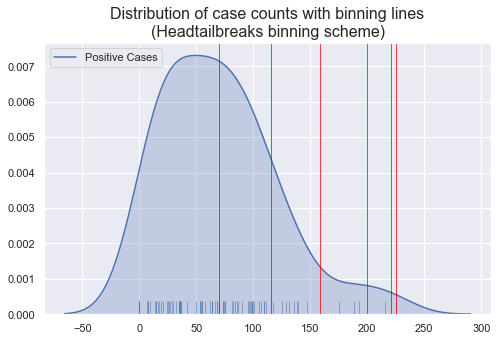

In [29]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='headtailbreaks', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)

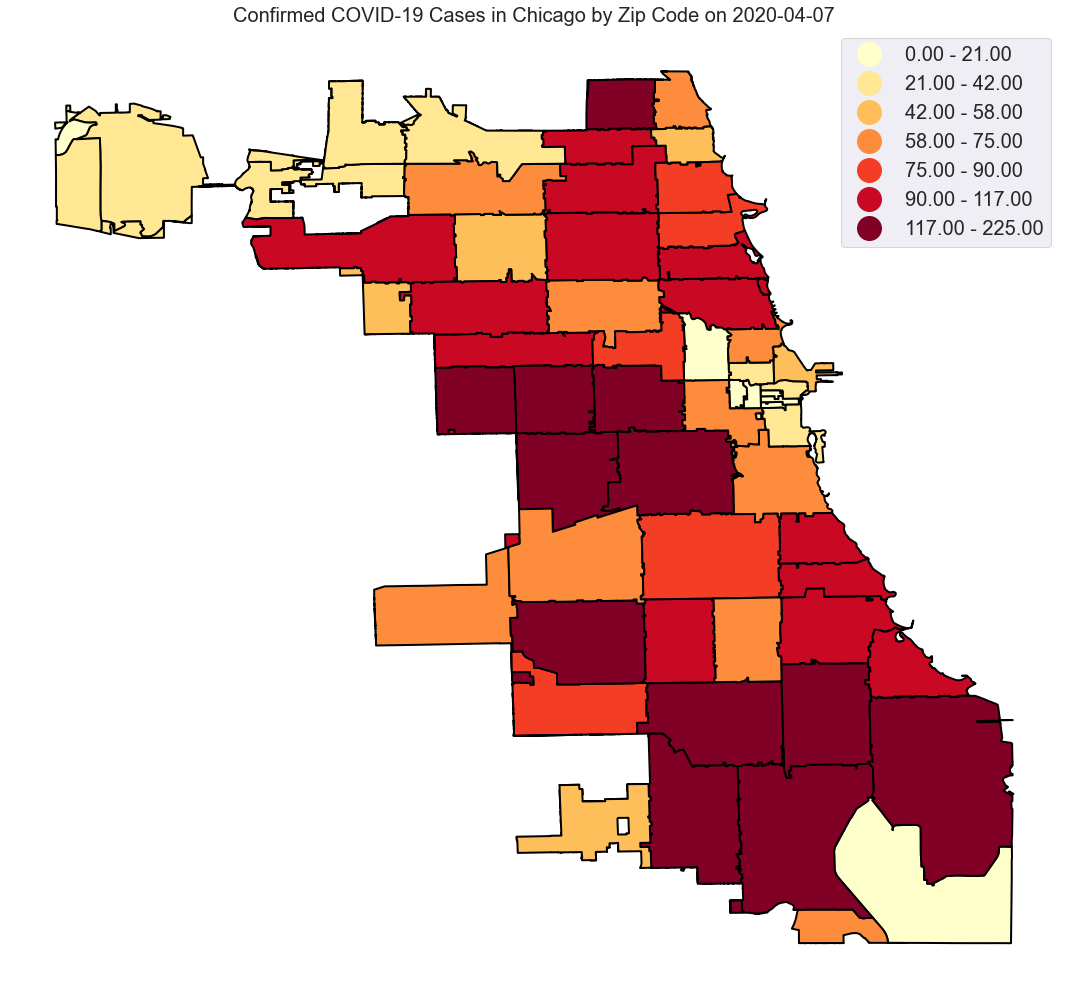

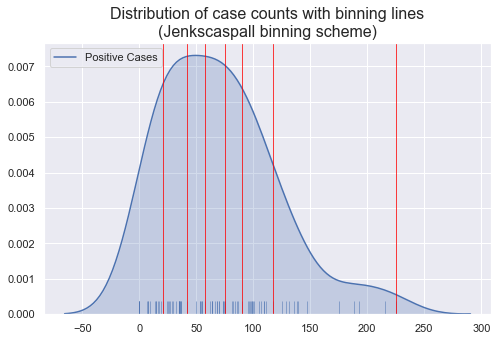

In [30]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='jenkscaspall', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)

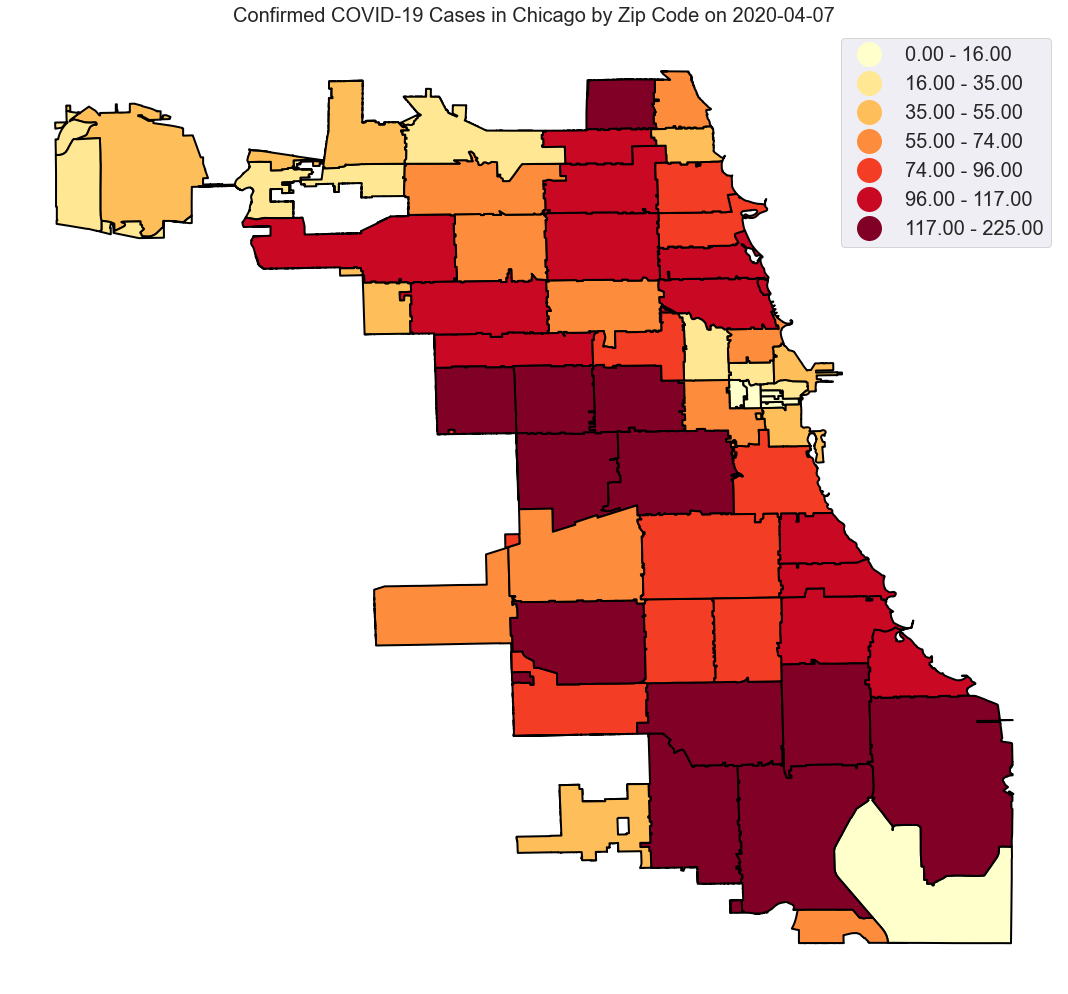

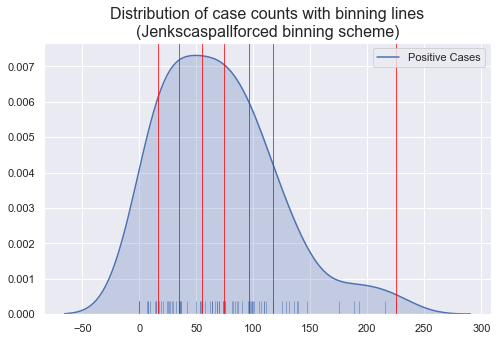

In [31]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='jenkscaspallforced', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)

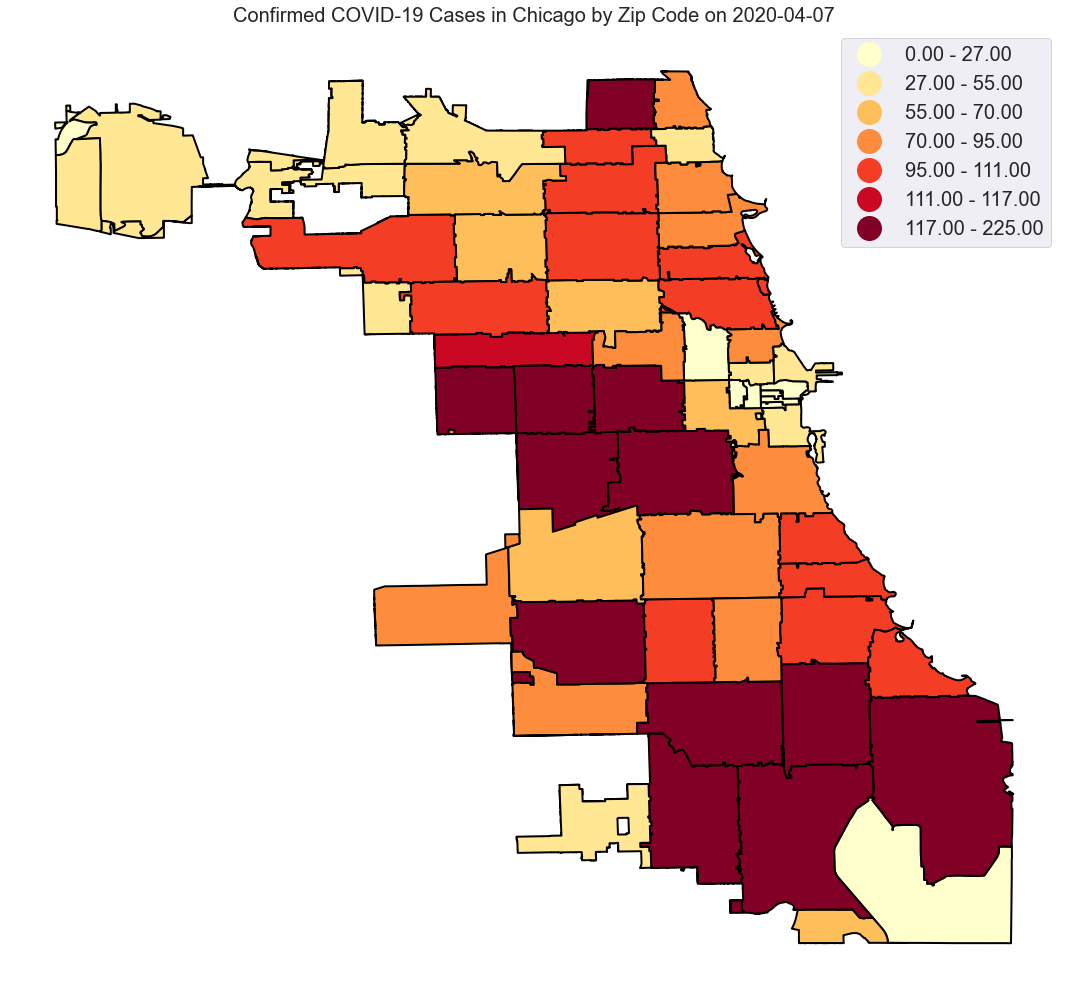

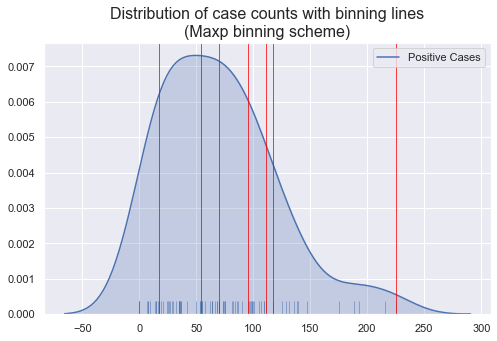

In [32]:
map_covid19_cases_by_location_bin_scheme(gdf=covid_by_zip_chicago_gdf, location='Chicago', scheme='maxp', k=7, figsize=(15,15), scale=0.6, 
                                             alpha=1, cmap=mpl.cm.YlOrRd, col='Positive Cases', include_dist=True)